# ML Regression Method Comparison - time series
Datasets:
    - https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset
    - file name : "day.csv" or "hour.csv"
Methods:
    - Linear Regression [Polynomial, etc...]
    - Linear Regression with basis funtions
    - Conditional Random Fields
    - Neural Net
    - LTSM
    - KDE

# Read Me stuff from data
Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv
	- instant: record index
	- dteday : date
	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

Remove holiday, random forest - reduce dimensionality bsed

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import random as rand
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
# Data ingest
df = pd.read_csv('day.csv')
print(df.shape)
print(df.head(5))

(731, 16)
   instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1        0        6           0   
1        2  2011-01-02       1   0     1        0        0           0   
2        3  2011-01-03       1   0     1        0        1           1   
3        4  2011-01-04       1   0     1        0        2           1   
4        5  2011-01-05       1   0     1        0        3           1   

   weathersit      temp     atemp       hum  windspeed  casual  registered  \
0           2  0.344167  0.363625  0.805833   0.160446     331         654   
1           2  0.363478  0.353739  0.696087   0.248539     131         670   
2           1  0.196364  0.189405  0.437273   0.248309     120        1229   
3           1  0.200000  0.212122  0.590435   0.160296     108        1454   
4           1  0.226957  0.229270  0.436957   0.186900      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600  


# Preprocessing/ EDA

In [4]:
# Seperate indices from data from labels
index, data, count_casual,count_registered, count = df['instant'] , df.iloc[1:-2], df['casual'], df['registered'], df['cnt']
data.info()
print("Are There Missing Data? :",data.isnull().any().any())
# distplot(x)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 1 to 728
Data columns (total 16 columns):
instant       728 non-null int64
dteday        728 non-null object
season        728 non-null int64
yr            728 non-null int64
mnth          728 non-null int64
holiday       728 non-null int64
weekday       728 non-null int64
workingday    728 non-null int64
weathersit    728 non-null int64
temp          728 non-null float64
atemp         728 non-null float64
hum           728 non-null float64
windspeed     728 non-null float64
casual        728 non-null int64
registered    728 non-null int64
cnt           728 non-null int64
dtypes: float64(4), int64(11), object(1)
memory usage: 91.1+ KB
Are There Missing Data? : False


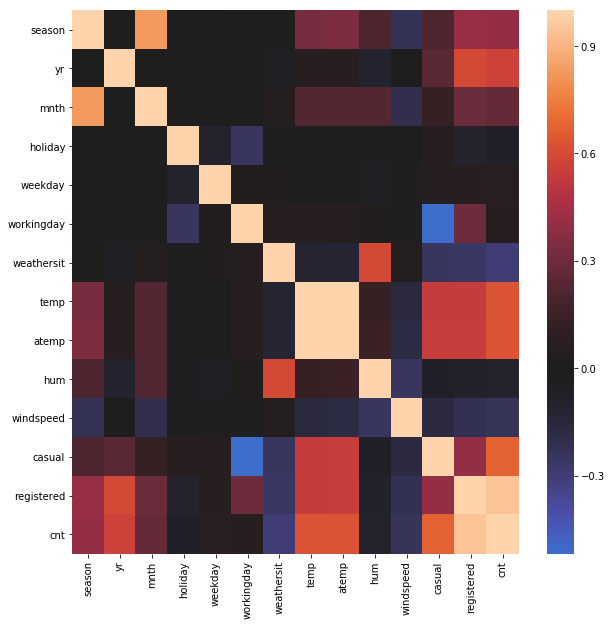

In [5]:
corr = df.iloc[:,1:].corr()

plt.figure(figsize = (10,10))
sns.heatmap(corr, center = 0 )

In [6]:
# Apply transform to fix date issue
import datetime
def fix_date(date):
    d = date.strip().split('-')
    dt = datetime.datetime(int(d[0]),int(d[1]),int(d[2]))
    # Note I ignore timezones and the like and just let python default to whatever as it is a simple linear shift.
    return dt.timestamp()
data['dteday'] = data['dteday'].apply(fix_date)
print(data.head())

   instant        dteday  season  yr  mnth  holiday  weekday  workingday  \
1        2  1.293948e+09       1   0     1        0        0           0   
2        3  1.294034e+09       1   0     1        0        1           1   
3        4  1.294121e+09       1   0     1        0        2           1   
4        5  1.294207e+09       1   0     1        0        3           1   
5        6  1.294294e+09       1   0     1        0        4           1   

   weathersit      temp     atemp       hum  windspeed  casual  registered  \
1           2  0.363478  0.353739  0.696087   0.248539     131         670   
2           1  0.196364  0.189405  0.437273   0.248309     120        1229   
3           1  0.200000  0.212122  0.590435   0.160296     108        1454   
4           1  0.226957  0.229270  0.436957   0.186900      82        1518   
5           1  0.204348  0.233209  0.518261   0.089565      88        1518   

    cnt  
1   801  
2  1349  
3  1562  
4  1600  
5  1606  


/home/badmin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Linear Regression
Methods
    - Least Squares (L2)
    - Lasso (L1)
    - Ridge

In [7]:
from sklearn import model_selection
from sklearn import linear_model

In [42]:
# Least Squares
def linear_reg(x_train, x_test, y_train, y_test):
    print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)
    # y_train.to_frame()
    # y_test.to_frame()
    # y_train.reshape((y_train.shape[0],1))
    # y_test.reshape((y_test.shape[0],1))
    # print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)
    if(x_test.shape[0] == 179):
        print(x_test,y_test)
    reg = linear_model.LinearRegression()
    reg.fit(x_train, np.array(y_train))
    pred = reg.predict(x_test)
    # return reg.score(x_test, y_test)
    return sk.metrics.mean_squared_error(np.array(y_test),pred)

In [43]:
cv = model_selection.TimeSeriesSplit()
cnt_list = []
cnt_cas_list = []
cnt_reg_list = []
for train_i, test_i in cv.split(df):
    print("Train start: {}\nTest start: {}\nTest end: {}".format(train_i[-1], test_i[0], test_i[-1]))
    x_train, x_test = data[train_i[0]:train_i[-1]], data[test_i[0]:test_i[-1]]
    count_train, count_test = count[train_i[0]:train_i[-1]], count[test_i[0]:test_i[-1]]
    cnt_cas_train, cnt_cas_test = count_casual[train_i[0]:train_i[-1]], count_casual[test_i[0]:test_i[-1]]
    cnt_reg_train, cnt_reg_test = count_registered[train_i[0]:train_i[-1]], count_registered[test_i[0]:test_i[-1]]
    count_acc = linear_reg(x_train, x_test, count_train, count_test)
    cnt_cas_acc = linear_reg(x_train, x_test, cnt_cas_train, cnt_cas_test)
    cnt_reg_acc = linear_reg(x_train, x_test, cnt_reg_train, cnt_reg_test)
    cnt_list.append(count_acc)
    cnt_cas_list.append(cnt_cas_acc)
    cnt_reg_list.append(cnt_reg_acc)
    print("Average MSE for predicting total count is: {}".format(np.mean(cnt_list)))
    print("Average MSE for predicting casual count is: {}".format(np.mean(cnt_cas_list)))
    print("Average MSE for predicting registered count is: {}".format(np.mean(cnt_reg_list)))
    print()

Train start: 184
Test start: 185
Test end: 366
(184, 16) (181, 16) (184,) (181,)
(184, 16) (181, 16) (184,) (181,)
(184, 16) (181, 16) (184,) (181,)
Average MSE for predicting total count is: 3847479.8666982874
Average MSE for predicting casual count is: 324202.8202539991
Average MSE for predicting registered count is: 2192455.581378364

Train start: 366
Test start: 367
Test end: 548
(366, 16) (181, 16) (366,) (181,)
(366, 16) (181, 16) (366,) (181,)
(366, 16) (181, 16) (366,) (181,)
Average MSE for predicting total count is: 2803619.3685509386
Average MSE for predicting casual count is: 338576.09624416253
Average MSE for predicting registered count is: 1514429.2864676523

Train start: 548
Test start: 549
Test end: 730
(548, 16) (179, 16) (548,) (181,)
     instant        dteday  season  yr  mnth  holiday  weekday  workingday  \
550      551  1.341378e+09       3   1     7        1        3           0   
551      552  1.341464e+09       3   1     7        0        4           1   
552

ValueError: Found input variables with inconsistent numbers of samples: [181, 179]

In [ ]:
# Ridge
def ridge_reg(alpha, x_train, x_test, y_train, y_test):
    reg = linear_model.Ridge(alpha=alpha)
    reg.fit(x_train, y_train)
    pred = reg.predict(x_test, y_test)
    return sk.metrics.accuracy_score(y_test,pred)

In [ ]:
# Lasso
def lasso_reg(alpha, x_train, x_test, y_train, y_test):
    reg = linear_model.Lasso(alpha=alpha)
    reg.fit(x_train, y_train)
    pred = reg.predict(x_test, y_test)
    return sk.metrics.accuracy_score(y_test,pred)

# Linear Regression with Basis Functions

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(x=2)

def polynomial_reg(x_train, x_test, y_train, y_test):
    # Iterate over powers for polynomial transform. 

# Neural Nets
With the dataset it is not possible to use Neural Networks (Thet choice in this case would be LSTMs) due to lack of data. 

# Kernel Density Estimation
Idea: Use kernel density estimators in a piecewise fashion to create a probability distribution for some time before the current